In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples3.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.14.,-_-_tWH,9.57_5.75_10.04,0,0,1,1,0,...,1,0,0,0,1,0,0,9,2,0
1,1b23.cif1_R,123,R.4SU.8.R.A.13.R.A.46.,-_-_cSS,9.57_12.47_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,123,R.A.13.R.G.15.R.A.46.,-_-_-,10.88_14.44_12.47,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
3,1b23.cif1_R,110,R.A.14.R.A.46.R.G.52.,t.W_-_-,12.76_21.27_28.07,0,0,1,0,1,...,1,0,0,0,1,0,0,7,3,0
4,1b23.cif1_R,110,R.A.9.R.A.13.R.G.30.,tHW_-_-,11.7_28.0_21.92,0,0,1,0,0,...,1,0,0,0,1,0,0,9,4,0


In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1316, '3j79.cif1_A': 965, '3j7p.cif1_S2': 765, '6ha1.cif1_a': 644, '6az1.cif1_1': 584, '3jam.cif1_2': 507, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 342, '4p95.cif1_A': 89, '1u9s.cif1_A': 72, '3j79.cif1_B': 63, '3j7o.cif1_7': 58, '4ioa.cif1_Y': 54, '4yaz.cif1_R': 48, '5fjc.cif1_A': 45, '5tbw.cif1_AS': 43, '4oqu.cif1_A': 38, '2r8s.cif1_R': 34, '4uyk.cif1_R': 33, '2der.cif1_D': 32, '3v7e.cif1_C': 32, '3iwn.cif1_A': 31, '4qk9.cif1_A': 29, '5aj0.cif1_Bv': 27, '3dil.cif1_A': 26, '6gaz.cif1_AV': 26, '4v8n.cif1_CV': 25, '5u3g.cif1_B': 25, '3skl.cif1_B': 24, '4qlm.cif1_A': 24, '6gaw.cif1_BB': 24, '1qf6.cif1_B': 23, '3d2v.cif1_A': 23, '3wfs.cif1_A': 22, '5jup.cif1_EC': 21, '1ser.cif1_T': 20, '3rkf.cif1_C': 20, '5oql.cif1_2': 20, '1y26.cif1_X': 19, '4y1m.cif1_B': 19, '5lzs.cif1_3': 19, '1y27.cif1_X': 18, '5b63.cif1_D': 17, '5t5h.cif1_C': 17, '4rge.cif1_C': 16, '4xnr.cif1_X': 16, '5ktj.cif1_A': 14, '4enc.cif1_A': 13, '4wfl.cif1_A': 12, '1et4.cif1_A': 11, '3jcs.cif1_3

111 A.G.6.A.C.261.A.A.557. cWW_-_cH. 10.81_15.03_13.22 PROBA:  0.14013338183482077
111 A.U.8.A.A.259.A.A.556. -_cSW_tWH 8.61_9.14_9.35 PROBA:  0.18691536998439717
111 A.C.18.A.G.223.A.A.570. cWW_tSW_- 10.87_9.63_11.19 PROBA:  0.26356491866244275
111 A.A.19.A.U.222.A.A.569. cWW_-_cSW 10.43_11.16_9.37 PROBA:  0.3072739304751128
111 A.U.282.A.A.319.A.G.338. -_cWS_cWW 12.03_9.76_10.44 PROBA:  0.37859305318024083
111 A.A.285.A.U.318.A.C.321. -_t.H_tWW 7.71_9.24_12.26 PROBA:  0.33074281301980035
111 A.G.289.A.C.313.A.G.325. cWW_cHH_- 10.72_13.03_13.31 PROBA:  0.4295745325043913
CONFUSION MATRIX By chain:  4p95.cif1_A
[[77  0]
 [ 7  5]]

123 B.C.29.B.C.36.B.U.45. -_-_- 21.63_4.9_17.31 PROBA:  0.563668912312357
112 B.G.22.B.U.24.B.C.26. -_-_- 10.57_10.56_10.26 PROBA:  0.7775900577731153
CONFUSION MATRIX By chain:  3j79.cif1_B
[[52  2]
 [ 0  9]]

111 Bv.U.16.Bv.U.20.Bv.U.59. cSH_tWW_tWW 9.66_10.69_8.21 PROBA:  0.22046045817702078
CONFUSION MATRIX By chain:  5aj0.cif1_Bv
[[23  0]
 [ 1  3]]

CONF

110 C.A.21.C.U.22.C.U.75. -_-_cWW 5.89_11.88_10.52 PROBA:  0.6254844274812793
112 C.A.21.C.U.49.C.U.75. -_-_cWW 7.17_9.63_10.52 PROBA:  0.583382858914787
CONFUSION MATRIX By chain:  3rkf.cif1_C
[[15  2]
 [ 0  3]]

110 B.G.10.B.G.12.B.A.98. -_-_- 6.21_10.72_8.95 PROBA:  0.807001511755629
111 B.G.8.B.U.48.B.C.101. cWW_tWS_cWW 8.2_7.99_10.59 PROBA:  0.31115276847612483
111 B.A.11.B.C.43.B.G.65. -_cWW_tWS 5.89_10.46_8.49 PROBA:  0.3063593860071033
CONFUSION MATRIX By chain:  4y1m.cif1_B
[[15  1]
 [ 2  1]]

111 7.G.9.7.G.12.7.A.22. -_cWW_tHH 11.53_12.17_11.32 PROBA:  0.27832675106668964
CONFUSION MATRIX By chain:  3j7a.cif1_7
[[2 0]
 [1 0]]

CONFUSION MATRIX By chain:  2oiu.cif1_Q
[[3]]

110 A.G.22.A.G.27.A.A.65. -_-_- 19.6_10.89_17.93 PROBA:  0.5105671175626493
111 A.A.23.A.G.69.A.A.127. cWW_tSW_- 12.88_9.92_13.4 PROBA:  0.34478609224332096
111 A.U.24.A.G.68.A.A.126. -_cWH_cSW 12.42_10.96_9.21 PROBA:  0.19995632563004473
CONFUSION MATRIX By chain:  3dil.cif1_A
[[21  1]
 [ 2  2]]

123 3.U.8

CONFUSION MATRIX By chain:  4qk9.cif1_A
[[25  0]
 [ 0  4]]

111 A.G.207.A.C.222.A.U.223. cWW_-_tW. 10.65_6.18_11.8 PROBA:  0.3909741545480572
111 A.G.210.A.C.218.A.G.228. ..._cWW_cWH 14.42_10.57_11.66 PROBA:  0.36540535070636665
CONFUSION MATRIX By chain:  1et4.cif1_A
[[8 0]
 [2 1]]

110 C.U.34.C.G.39.C.A.103. -_tSH_- 19.07_8.97_19.28 PROBA:  0.5144899273680621
CONFUSION MATRIX By chain:  5t5h.cif1_C
[[13  1]
 [ 0  3]]

111 S2.G.7.S2.G.16.S2.A.1195. cWW_tSH_- 12.59_9.54_9.4 PROBA:  0.24570413960539297
111 S2.G.10.S2.U.1201.S2.A.1697. cWW_cWW_- 11.68_13.43_5.54 PROBA:  0.06456843837254381
111 S2.U.12.S2.A.1199.S2.G.1356. cWW_-_cSS 10.62_12.72_5.41 PROBA:  0.49154953985251804
111 S2.C.35.S2.A.520.S2.A.825. cWW_cSS_- 9.93_5.49_12.49 PROBA:  0.18332240281880494
111 S2.A.61.S2.G.316.S2.C.334. cSS_cWW_- 5.12_10.89_8.19 PROBA:  0.2785081162095356
111 S2.A.91.S2.A.92.S2.U.443. cHW_tHW_- 8.03_12.08_12.28 PROBA:  0.10244599287484524
111 S2.C.106.S2.A.107.S2.U.354. cWH_cWW_- 5.67_10.4_13.16 PROBA

AUC_TRAIN =  0.995540970324177

AUC =  0.9834912896909507


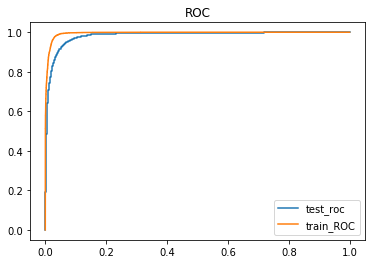

Probability density for train


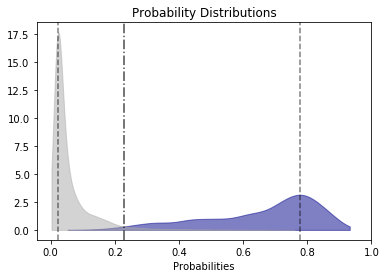

Probability density for test


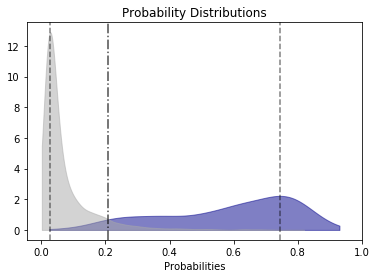


[[5824   56]
 [ 317  694]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5824   56  5880
1           317  694  1011
All        6141  750  6891


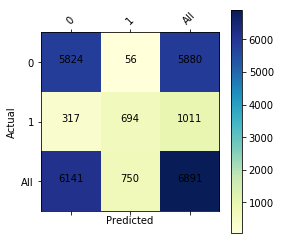


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5880
          1       0.93      0.69      0.79      1011

avg / total       0.94      0.95      0.94      6891

ACCURACY =  0.9458714264983311
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 993, '5mrc.cif1_A': 833, '6d9j.cif1_5': 726, '5ool.cif1_A': 571, '3j7a.cif1_A': 489, '5xyi.cif1_2': 428, '6d9j.cif1_2': 381, '1u6b.cif1_B': 76, '5fdv.cif1_1B': 72, '3igi.cif1_A': 63, '4gxy.cif1_A': 55, '5xy3.cif1_3': 53, '3mxh.cif1_R': 46, '4r4v.cif1_A': 44, '6ha1.cif1_B': 42, '4qk8.cif1_A': 37, '3ndb.cif1_M': 33, '6d9j.cif1_7': 33, '4prf.cif1_B': 32, '5e6m.cif1_C': 32, '3u4m.cif1_B': 30, '4mgn.cif1_A': 29, '6eri.cif1_AB': 27, '2qus.cif1_A': 26, '1fir.cif1_A': 25, '2csx.cif1_C': 25, '3kfu.cif1_L': 25, '1u0b.cif1_A': 24, '5mgp.cif1_x': 24, '3ski.cif1_A': 23, '5axm.cif1_P': 23, '2xdb.cif1_G': 22, '4gcw.cif1_B': 21, '5xy3.cif1_4': 21, '3g9c.cif1_Q': 20, '5aox.cif1_C

112 A.U.136.A.G.264.A.U.297. -_-_- 23.46_6.82_24.97 PROBA:  0.7385700178762845
112 A.U.1394.A.U.1407.A.A.1424. -_-_cWW 16.48_12.0_10.51 PROBA:  0.7165029825960858
111 A.A.11.A.A.1244.A.A.1402. cWW_tSW_cWS 12.05_8.99_5.59 PROBA:  0.051798436752884765
111 A.U.32.A.A.474.A.A.601. tWH_cWS_- 9.64_9.18_8.43 PROBA:  0.2804041223927308
111 A.A.47.A.U.100.A.A.391. cHS_cWW_- 7.7_10.55_12.08 PROBA:  0.42712944086115023
111 A.A.61.A.C.270.A.G.292. cWS_cWW_tW. 6.17_10.96_12.89 PROBA:  0.3981846193391986
111 A.A.62.A.A.269.A.U.293. -_cWW_tWS 5.66_10.38_8.49 PROBA:  0.3885771286816595
111 A.A.110.A.U.312.A.A.857. cWW_tSH_- 10.32_10.12_9.25 PROBA:  0.23136968554943807
111 A.U.115.A.G.307.A.U.340. cWW_tSW_- 10.2_9.28_9.18 PROBA:  0.319957740709113
111 A.U.168.A.C.268.A.G.294. -_cWW_tHW 5.19_10.54_11.05 PROBA:  0.2902409429074027
111 A.G.369.A.C.387.A.A.805. cWW_cSW_c.H 10.68_8.73_12.99 PROBA:  0.36736965354001816
111 A.G.370.A.G.383.A.A.806. tHS_-_tSW 10.31_18.67_9.66 PROBA:  0.3243493267436285
111 A.A

110 A.A.2377.A.U.2439.A.G.2609. -_cWW_- 40.74_11.89_33.94 PROBA:  0.6710886601252966
111 A.G.112.A.C.146.A.A.157. cWW_-_tSS 10.8_5.79_8.25 PROBA:  0.3693707790933243
111 A.G.227.A.C.249.A.A.1386. cWW_-_cSW 10.78_12.96_6.82 PROBA:  0.3416952262522513
111 A.A.231.A.A.244.A.G.587. tHH_-_cSS 10.97_16.54_5.81 PROBA:  0.10030228357530872
111 A.A.263.A.G.345.A.C.357. t.S_cWW_- 8.24_10.46_5.62 PROBA:  0.4176735030069164
111 A.C.268.A.U.348.A.A.354. -_cHW_cWS 16.38_12.92_7.84 PROBA:  0.2552319186594703
111 A.C.268.A.A.353.A.U.2674. -_cWW_cHS 11.97_10.7_8.18 PROBA:  0.3893828235269581
111 A.U.286.A.G.292.A.A.327. cWW_tSW_- 10.4_8.53_7.92 PROBA:  0.3415651047343156
111 A.A.396.A.C.592.A.G.685. cSS_cWW_- 5.64_10.78_13.23 PROBA:  0.39119301277070717
111 A.A.429.A.A.1919.A.G.1935. -_cWW_cWW 9.76_12.69_11.26 PROBA:  0.4081887983594488
111 A.A.520.A.C.2668.A.G.2682. -_cWW_cWS 12.75_10.59_5.85 PROBA:  0.21767318247721362
111 A.A.608.A.G.624.A.G.1585. tHS_-_cWS 9.47_9.93_5.53 PROBA:  0.32924256684189923

111 5.A.372.5.G.1530.5.C.1644. cSS_cWW_- 5.98_10.91_8.45 PROBA:  0.27957206376645943
111 5.A.419.5.C.1332.5.G.2354. cWS_cWW_- 6.31_10.81_13.83 PROBA:  0.3611489785651669
111 5.G.965.5.C.969.5.G.2096. -_cWW_tSS 7.82_10.0_7.43 PROBA:  0.15567961626744592
111 5.C.1313.5.G.3874.5.G.3879. -_tWH_cWW 14.02_11.5_10.07 PROBA:  0.47379336688811213
111 5.C.1315.5.G.1328.5.G.2348. cWW_-_tSW 11.67_9.18_9.19 PROBA:  0.30690295364663395
111 5.A.1391.5.A.4348.5.G.4364. -_cWW_cWS 17.03_13.75_6.68 PROBA:  0.17648925935698428
111 5.A.1524.5.G.1651.5.U.3915. tWW_-_tHS 13.71_14.09_6.96 PROBA:  0.14467568494135669
111 5.C.1541.5.G.1618.5.G.2448. cWW_-_cSS 10.8_14.22_6.05 PROBA:  0.29788302132524547
111 5.G.1586.5.C.1607.5.A.3828. cWW_cSW_t.W 10.73_6.93_12.37 PROBA:  0.4241452300516906
111 5.A.1630.5.G.3638.5.C.3650. tWS_cWW_- 8.85_10.82_6.21 PROBA:  0.4842685956191105
111 5.C.1662.5.G.2287.5.G.2321. cWW_-_cSS 10.83_13.1_4.22 PROBA:  0.3512979425631279
111 5.A.1679.5.U.3912.5.A.4390. cHS_cWW_- 8.38_10.71_11.

AUC_TRAIN =  0.9949330865388807

AUC =  0.9850882942530957


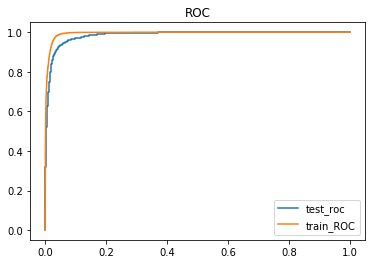

Probability density for train


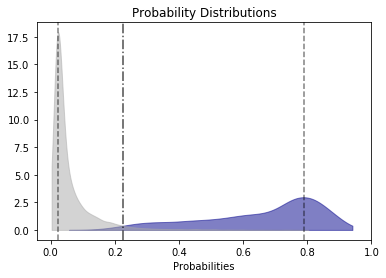

Probability density for test


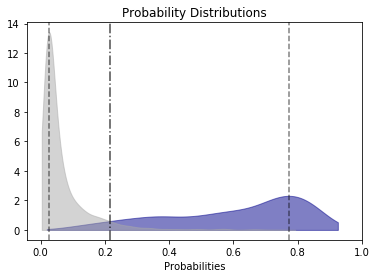


[[5816   61]
 [ 307  707]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   61  5877
1           307  707  1014
All        6123  768  6891


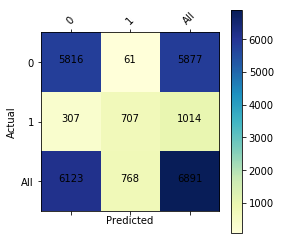


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5877
          1       0.92      0.70      0.79      1014

avg / total       0.95      0.95      0.94      6891

ACCURACY =  0.9465970105935277
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1012, '5tbw.cif1_1': 936, '4v88.cif1_A6': 637, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 156, '1nbs.cif1_B': 65, '2a64.cif1_A': 62, '5j7l.cif1_DB': 55, '6ek0.cif1_L7': 50, '6az3.cif1_8': 46, '4kqy.cif1_A': 43, '6d90.cif1_4': 40, '5lys.cif1_B': 34, '5t83.cif1_A': 33, '5wt1.cif1_C': 33, '4yye.cif1_C': 32, '1h4s.cif1_T': 31, '4lck.cif1_F': 30, '5tbw.cif1_4': 27, '2du3.cif1_D': 26, '4p5j.cif1_A': 26, '6az3.cif1_5': 25, '6ck5.cif1_A': 25, '2gdi.cif1_X': 24, '4qei.cif1_C': 24, '5o2r.cif1_x': 24, '2azx.cif1_D': 23, '5d8h.cif1_A': 23, '5ns3.cif1_C': 22, '6ek0.cif1_L8': 21, '1n78.cif1_C': 20, '3w3s.cif1_B': 20, '4lx

CONFUSION MATRIX By chain:  4y4o.cif1_2A
[[948   6]
 [ 47 112]]

110 B.U.40.B.A.43.B.G.64. cWH_-_- 8.29_15.7_14.0 PROBA:  0.5215008725176417
111 B.A.34.B.C.38.B.G.69. -_cWW_tWH 13.12_10.7_12.06 PROBA:  0.1757381910252932
0 B.U.32.B.U.76.B.G.82. -_-_- 21.81_22.4_10.58 PROBA:  0.5618181857621082
CONFUSION MATRIX By chain:  5lys.cif1_B
[[26  2]
 [ 1  5]]

123 C.U.513.C.G.523.C.C.548. -_-_- 8.12_16.21_13.09 PROBA:  0.5050556318185349
112 C.U.513.C.G.523.C.A.546. -_-_- 8.12_13.72_11.58 PROBA:  0.581855393666179
112 C.A.514.C.U.520.C.A.521. -_-_cWS 12.04_6.34_9.41 PROBA:  0.6367361388021383
111 C.G.515.C.U.520.C.C.548. cSW_t.W_tWW 9.28_13.03_10.72 PROBA:  0.2328846493479062
CONFUSION MATRIX By chain:  1n78.cif1_C
[[13  3]
 [ 1  3]]

110 4.A.6056.4.G.6067.4.U.6171. -_-_- 22.66_14.5_26.3 PROBA:  0.5637901879986539
100 4.G.6163.4.U.6171.4.U.6210. -_-_- 38.94_29.06_43.95 PROBA:  0.611885445733909
111 4.U.6105.4.U.6132.4.A.6154. tWH_cWW_- 11.69_10.24_12.23 PROBA:  0.4307647266441551
111 4.A.6121.

111 A.G.10.A.U.11.A.C.49. cSH_-_cWW 6.41_11.89_10.46 PROBA:  0.3133137104651956
120 A.A.41.A.G.71.A.G.72. -_-_- 13.55_6.05_10.23 PROBA:  0.5088946208389576
CONFUSION MATRIX By chain:  4p5j.cif1_A
[[21  1]
 [ 1  3]]

CONFUSION MATRIX By chain:  3ktw.cif1_C
[[7 0]
 [0 2]]

111 1.A.649.1.C.852.1.G.871. -_cWW_tSS 5.81_10.86_8.06 PROBA:  0.2772481534870123
111 1.U.696.1.U.888.1.C.889. cWW_-_cSW 8.56_7.43_7.89 PROBA:  0.47303796845444057
111 1.G.910.1.G.921.1.C.926. cHW_t.W_- 11.14_13.1_10.26 PROBA:  0.32176630119638966
111 1.C.1209.1.A.1524.1.A.1559. cSW_-_cWW 6.2_12.73_10.9 PROBA:  0.46144390830944554
111 1.A.2066.1.G.2173.1.C.2189. tWS_cWW_- 10.59_10.88_9.7 PROBA:  0.4241633372938437
111 1.G.2067.1.C.2174.1.G.2188. tWS_cWW_- 8.94_10.74_10.88 PROBA:  0.34118820102688585
CONFUSION MATRIX By chain:  5oql.cif1_1
[[134   0]
 [  6  16]]

CONFUSION MATRIX By chain:  5wti.cif1_B
[[14  0]
 [ 0  2]]

111 8.C.119.8.G.120.8.C.130. cWH_cWW_- 5.72_10.36_13.94 PROBA:  0.40581332895424466
CONFUSION MATRI

110 A6.G.549.A6.C.589.A6.U.611. cWW_-_- 10.54_52.97_45.76 PROBA:  0.5665505186800661
110 A6.G.143.A6.U.261.A6.U.262. -_cSH_- 22.39_6.72_23.31 PROBA:  0.7347645385715867
111 A6.A.62.A6.C.268.A6.G.287. -_cWW_tSS 5.88_10.62_8.52 PROBA:  0.311392820895591
111 A6.A.85.A6.A.148.A6.C.166. cWS_tHW_- 5.86_11.17_16.2 PROBA:  0.13695520846835288
111 A6.G.109.A6.C.305.A6.A.796. cWW_-_tSS 10.36_7.34_7.58 PROBA:  0.3834650796489376
111 A6.U.113.A6.A.301.A6.G.334. cWW_tSW_- 10.59_8.98_10.14 PROBA:  0.4517684766287558
111 A6.A.217.A6.U.828.A6.A.844. -_cWW_cHS 12.13_10.52_8.3 PROBA:  0.3661528771226651
111 A6.A.219.A6.U.830.A6.C.842. cHW_-_cWW 9.07_14.74_9.69 PROBA:  0.2093178767604204
111 A6.A.221.A6.U.832.A6.U.840. cHW_-_cWW 7.14_15.55_10.82 PROBA:  0.30951402231013647
111 A6.A.222.A6.U.833.A6.U.839. cHW_-_cWW 8.26_14.89_10.53 PROBA:  0.3737523189792131
111 A6.G.363.A6.C.381.A6.A.755. cWW_cSW_- 10.66_9.01_12.87 PROBA:  0.29791151917001274
111 A6.G.364.A6.G.377.A6.A.756. tHW_-_tSW 10.63_19.02_9.55 PRO

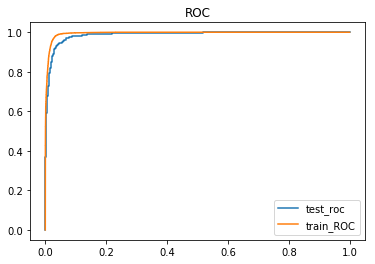

Probability density for train


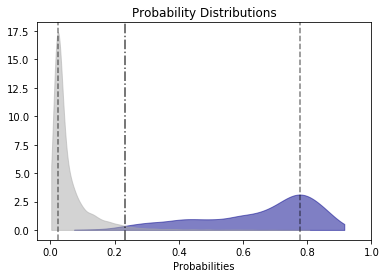

Probability density for test


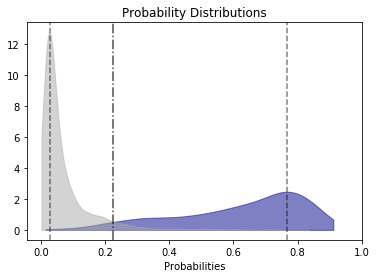


[[5805   66]
 [ 261  759]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5805   66  5871
1           261  759  1020
All        6066  825  6891


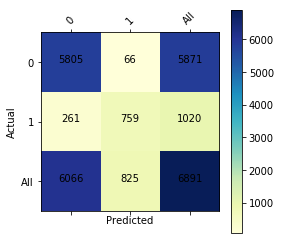


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5871
          1       0.92      0.74      0.82      1020

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9525468001741402
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1101, '6ha1.cif1_A': 1026, '5xxb.cif1_1': 845, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 546, '5xxu.cif1_2': 473, '5ngm.cif1_Aa': 462, '5t5h.cif1_B': 287, '6gaz.cif1_AA': 275, '4wf9.cif1_Y': 57, '5t5h.cif1_D': 53, '3ivk.cif1_M': 48, '5xym.cif1_B': 45, '4plx.cif1_A': 42, '4ycp.cif1_B': 38, '1c0a.cif1_B': 34, '4y1j.cif1_A': 33, '4rdx.cif1_C': 32, '3f2x.cif1_X': 31, '4wj4.cif1_B': 31, '1j1u.cif1_B': 28, '5ccb.cif1_N': 27, '3j79.cif1_C': 26, '5hr7.cif1_D': 26, '1evv.cif1_A': 25, '2d6f.cif1_F': 24, '6cb3.cif1_B': 24, '6d9j.cif1_8': 24, '1gax.cif1_D': 23, '3al0.cif1_E': 23, '5ool.cif1_B': 23, '1hc8.cif1_C': 21, '6az3.cif1_7': 21, '4jrc.cif1_B': 20, '6az3.cif1_3': 20, '3d0u.cif1_A': 19, '3ivn.ci

112 A.A.689.A.G.1362.A.C.1370. -_cWW_- 114.22_11.1_123.83 PROBA:  0.5371562788426609
112 A.G.493.A.A.496.A.A.518. -_-_- 6.45_16.26_19.1 PROBA:  0.7819528700846581
112 A.A.2083.A.U.2104.A.U.2644. -_-_cWW 56.05_61.02_10.88 PROBA:  0.6066895803635763
111 A.A.38.A.U.488.A.A.659. cWW_cSH_- 10.67_8.54_13.0 PROBA:  0.35828641380750986
111 A.C.39.A.G.487.A.A.659. cWW_-_cSW 10.72_11.15_9.09 PROBA:  0.3749621972080409
111 A.A.65.A.U.89.A.C.503. cWW_-_cSW 10.51_11.02_7.81 PROBA:  0.09011757730592418
111 A.G.80.A.C.105.A.A.337. cWW_-_tSS 10.57_6.14_8.12 PROBA:  0.20284520026016778
111 A.A.139.A.C.1447.A.G.1639. -_cWW_tWS 9.76_10.45_10.68 PROBA:  0.22105540877346538
111 A.A.194.A.A.207.A.G.846. tHH_-_tSS 10.88_11.83_8.17 PROBA:  0.13609383386116503
111 A.A.230.A.G.457.A.C.464. tWS_cWW_- 9.35_10.88_10.77 PROBA:  0.4170286978690503
111 A.G.248.A.C.256.A.A.431. cWW_-_tSS 10.83_7.34_7.93 PROBA:  0.2456181516242737
111 A.C.249.A.G.255.A.G.433. cWW_tW._- 10.82_12.7_7.74 PROBA:  0.3756677374592957
111 A.A

110 A.U.8.A.G.15.A.A.21. -_-_tSW 8.92_9.22_8.61 PROBA:  0.5340266213736437
112 A.A.9.A.U.12.A.G.22. -_-_- 11.23_14.11_9.72 PROBA:  0.5226507479203817
112 A.2MG.10.A.G.22.A.7MG.46. -_tHW_- 16.35_11.22_11.41 PROBA:  0.5825175712223768
CONFUSION MATRIX By chain:  1evv.cif1_A
[[18  3]
 [ 0  4]]

112 E.U.8.E.C.25.E.G.45. -_-_- 16.43_14.22_13.44 PROBA:  0.7063448702845072
CONFUSION MATRIX By chain:  3icq.cif1_E
[[10  1]
 [ 0  3]]

CONFUSION MATRIX By chain:  3j79.cif1_C
[[22  0]
 [ 0  4]]

111 A.U.31.A.U.40.A.A.71. -_cWW_cWH 15.13_10.25_8.37 PROBA:  0.46766514294824474
111 A.U.32.A.U.39.A.A.72. -_cWW_cWH 15.16_10.09_8.23 PROBA:  0.39307953618391783
CONFUSION MATRIX By chain:  4jf2.cif1_A
[[15  0]
 [ 2  1]]

110 S6.U.9.S6.A.15.S6.U.25. tWH_-_- 10.53_15.61_17.93 PROBA:  0.6247512376029568
112 S6.C.48.S6.A.50.S6.U.64. -_cWW_- 10.86_10.25_18.9 PROBA:  0.5370291454143007
111 S6.U.9.S6.A.15.S6.C.48. tWH_-_cSS 10.53_12.9_4.07 PROBA:  0.4731181490690677
111 S6.G.29.S6.G.31.S6.C.39. cSH_cWW_cWW 8.3_1

111 A.G.6.A.C.50.A.A.65. cWW_-_tSS 10.81_5.64_8.12 PROBA:  0.2931801847048492
111 A.U.7.A.U.47.A.A.66. -_cWW_cWH 14.81_10.03_8.36 PROBA:  0.33615300661074987
111 A.U.8.A.U.46.A.A.67. -_cWW_cWH 15.12_10.6_8.3 PROBA:  0.36440098142888483
111 A.U.9.A.U.45.A.A.68. -_cWW_cWH 15.06_10.77_8.02 PROBA:  0.42861303882857804
111 A.U.10.A.U.44.A.A.69. -_cWW_cWH 14.97_10.79_7.76 PROBA:  0.43867840574059147
111 A.U.11.A.U.43.A.A.70. -_cWW_cWH 15.36_10.51_8.25 PROBA:  0.3909367975941783
CONFUSION MATRIX By chain:  4plx.cif1_A
[[36  0]
 [ 6  0]]

110 B.G.8.B.G.11.B.U.12. -_cSH_- 11.87_7.45_8.3 PROBA:  0.7446260457793946
100 B.A.30.B.U.69.B.A.89. -_-_- 7.17_24.86_23.34 PROBA:  0.5760561440545388
112 B.C.37.B.C.60.B.G.61. -_-_cWW 13.8_5.06_10.67 PROBA:  0.5143042993383318
111 B.A.10.B.C.37.B.G.61. -_cWW_tSS 5.89_10.67_8.24 PROBA:  0.26275453289659423
CONFUSION MATRIX By chain:  6cb3.cif1_B
[[17  3]
 [ 1  3]]

111 X.G.11.X.C.31.X.G.84. cSS_cWW_- 5.28_10.66_12.6 PROBA:  0.16745924450515623
111 X.G.32.X.G.

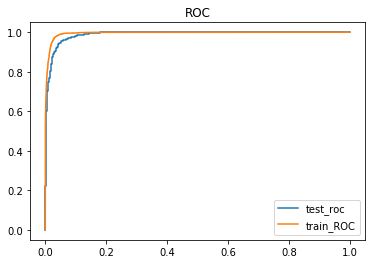

Probability density for train


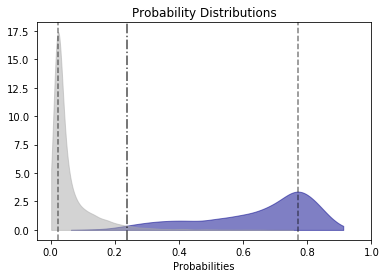

Probability density for test


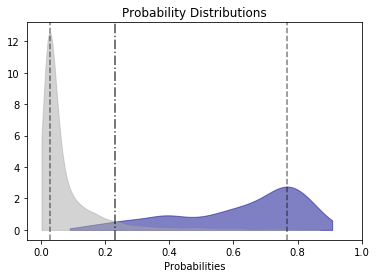


[[5819   56]
 [ 260  756]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5819   56  5875
1           260  756  1016
All        6079  812  6891


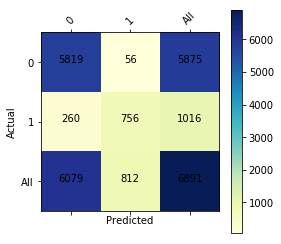


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5875
          1       0.93      0.74      0.83      1016

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9541430851835728
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1043, '5o60.cif1_A': 1038, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 652, '4lfb.cif1_A': 588, '6eri.cif1_BA': 543, '5an9.cif1_N': 413, '6az3.cif1_2': 284, '5t2a.cif1_B': 250, '4v9f.cif1_9': 59, '3pdr.cif1_X': 54, '5xxb.cif1_3': 49, '5ml7.cif1_B': 46, '6eri.cif1_Ax': 43, '2qwy.cif1_C': 39, '1yfg.cif1_A': 35, '4aob.cif1_A': 33, '1mfq.cif1_A': 32, '4pr6.cif1_B': 32, '3hhn.cif1_E': 31, '3wqy.cif1_C': 30, '4yco.cif1_D': 27, '3amu.cif1_B': 26, '6az3.cif1_4': 26, '3q3z.cif1_V': 25, '4mgn.cif1_B': 25, '1il2.cif1_C': 24, '1qtq.cif1_B': 24, '5mrc.cif1_bb': 24, '5hr6.cif1_C': 23, '5l4o.cif1_A': 23, '3eph.cif1_E': 22, '6cfj.cif1_1x': 21, '2xd0.cif1_W': 20, '5mmm.cif1_z': 20, '5zwn.cif1_P': 20, '1b23.

CONFUSION MATRIX By chain:  5xxb.cif1_4
[[16  0]
 [ 0  3]]

112 A.C.30.A.A.71.A.G.73. -_-_cWW 16.82_10.23_10.77 PROBA:  0.6510580792926325
CONFUSION MATRIX By chain:  3oxe.cif1_A
[[15  1]
 [ 0  3]]

112 B.U.-13.B.U.-8.B.G.-6. -_cWS_- 20.34_5.54_16.69 PROBA:  0.5708729871616873
CONFUSION MATRIX By chain:  5kk5.cif1_B
[[12  1]
 [ 0  1]]

111 A.G.29.A.A.37.A.C.41. tHW_-_cWW 12.12_13.19_10.92 PROBA:  0.47984220304938957
CONFUSION MATRIX By chain:  5l4o.cif1_A
[[19  0]
 [ 1  3]]

110 2.G.1255.2.A.1259.2.U.1265. cWH_-_- 13.17_21.38_21.96 PROBA:  0.7314351669606012
112 2.C.776.2.G.780.2.A.814. -_-_tWW 16.2_21.66_12.37 PROBA:  0.5983623001617834
112 2.U.1266.2.G.1267.2.G.1390. cSH_-_- 6.44_37.52_36.12 PROBA:  0.8134689166215792
111 2.G.396.2.U.432.2.A.559. cWW_cSS_- 10.37_4.71_12.2 PROBA:  0.2921327312850163
111 2.A2M.527.2.A.1397.2.U.1413. -_cWW_cSS 11.2_10.17_4.46 PROBA:  0.4190307414364149
111 2.A.619.2.G.1263.2.U.1304. cSS_cWW_- 5.02_10.92_13.58 PROBA:  0.27674008961840546
111 2.G.780.2.U.

CONFUSION MATRIX By chain:  6ek0.cif1_L5
[[889   5]
 [ 44 105]]

111 B.U.8.B.A.14.B.A.20.A tWH_cWS_tSW 9.87_9.69_8.32 PROBA:  0.4731278879183609
CONFUSION MATRIX By chain:  2bte.cif1_B
[[7 0]
 [1 1]]

123 B.G.37.B.G.39.B.A.42. -_-_- 9.92_8.81_10.91 PROBA:  0.7759791833754208
112 B.G.37.B.U.38.B.U.43. -_-_tWH 5.63_12.36_12.81 PROBA:  0.7649156348748499
111 B.A.10.B.A.15.B.G.39. tWH_tWS_- 11.78_9.64_6.09 PROBA:  0.22276281547620214
111 B.G.11.B.U.38.B.A.42. -_tWH_tSW 4.22_9.7_9.73 PROBA:  0.3674705787384754
111 B.A.13.B.G.37.B.U.43. -_tWH_cWW 13.95_12.81_10.61 PROBA:  0.31412382276986767
CONFUSION MATRIX By chain:  1mzp.cif1_B
[[13  2]
 [ 3  0]]

112 AW.C.13.AW.C.25.AW.G.46. -_-_- 11.72_17.43_14.65 PROBA:  0.5237815457647834
CONFUSION MATRIX By chain:  4v9k.cif1_AW
[[13  1]
 [ 0  3]]

CONFUSION MATRIX By chain:  5ddo.cif1_B
[[2 0]
 [0 1]]

112 D.U.8.D.C.11.D.G.24. -_cWW_- 12.82_10.59_15.29 PROBA:  0.5819786266599154
112 D.A.9.D.U.12.D.G.24. -_-_- 11.23_7.98_12.11 PROBA:  0.68967283363813

AUC_TRAIN =  0.9948276864444461

AUC =  0.9852436360656144


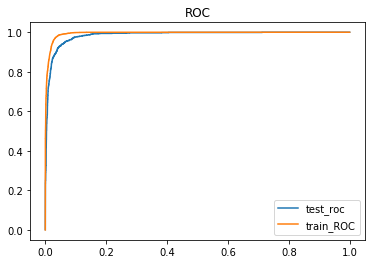

Probability density for train


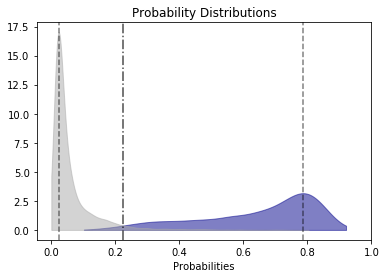

Probability density for test


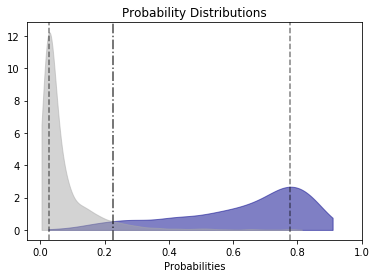


[[5801   77]
 [ 247  766]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5801   77  5878
1           247  766  1013
All        6048  843  6891


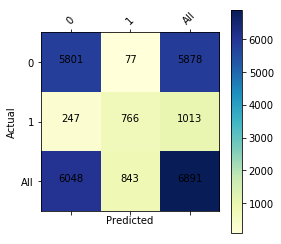


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5878
          1       0.91      0.76      0.83      1013

avg / total       0.95      0.95      0.95      6891

ACCURACY =  0.9529821506312581
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9947395300752606

AUC =  0.9840114331351875


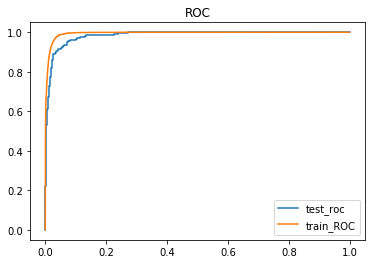

Probability density for train


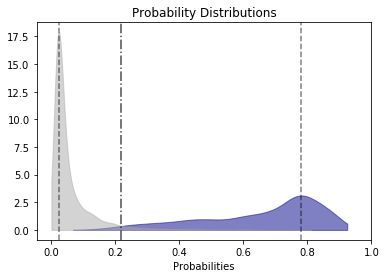

Probability density for test


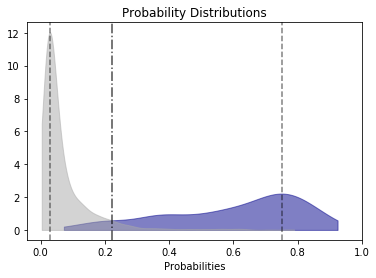


[[2902   36]
 [ 154  354]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2902   36  2938
1           154  354   508
All        3056  390  3446


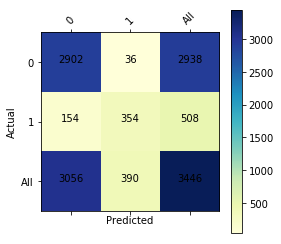

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.70      0.79       508

avg / total       0.94      0.94      0.94      3446

ACCURACY 0.9448636099825886
-----------------

AUC_TRAIN =  0.9947116185693443

AUC =  0.9870218103268065


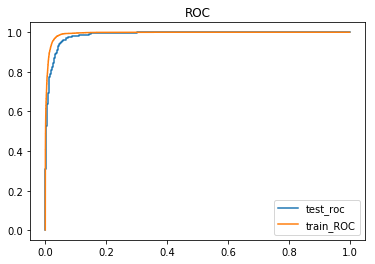

Probability density for train


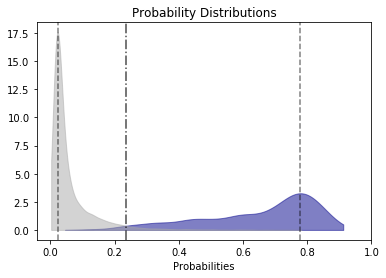

Probability density for test


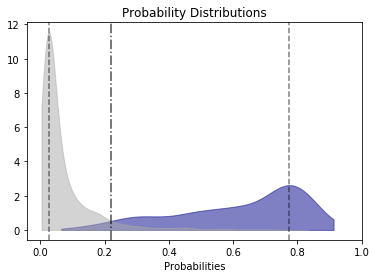


[[2904   34]
 [ 139  369]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2904   34  2938
1           139  369   508
All        3043  403  3446


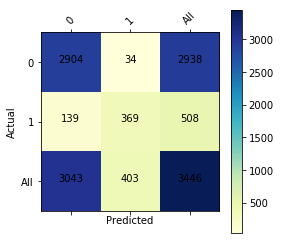

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.92      0.73      0.81       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9497968659315148
-----------------

AUC_TRAIN =  0.9947379067354506

AUC =  0.9852194700985726


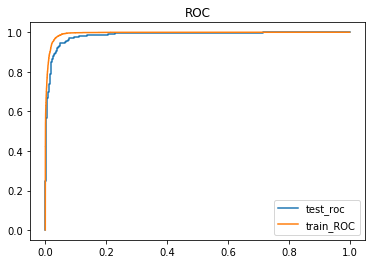

Probability density for train


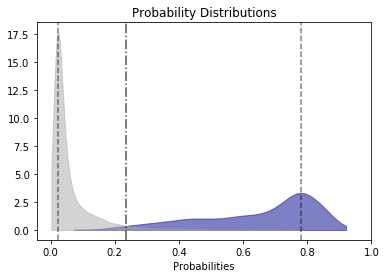

Probability density for test


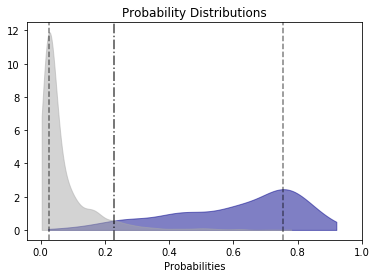


[[2904   34]
 [ 146  362]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2904   34  2938
1           146  362   508
All        3050  396  3446


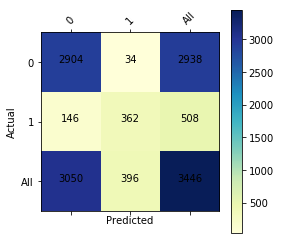

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.91      0.71      0.80       508

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9477655252466628
-----------------

AUC_TRAIN =  0.9948532398173483

AUC =  0.988637708047646


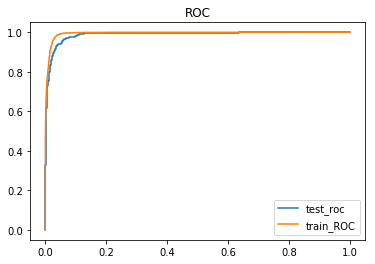

Probability density for train


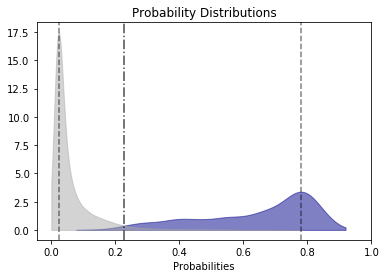

Probability density for test


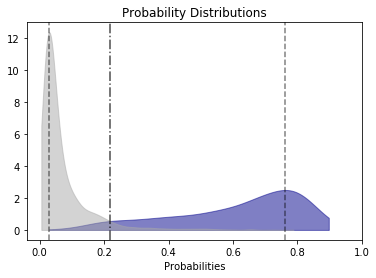


[[2913   27]
 [ 130  376]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2913   27  2940
1           130  376   506
All        3043  403  3446


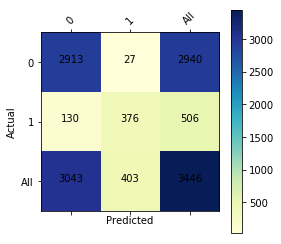

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2940
          1       0.93      0.74      0.83       506

avg / total       0.95      0.95      0.95      3446

ACCURACY 0.9544399303540336
-----------------

AUC_TRAIN =  0.9948630478145796

AUC =  0.9851624719057389


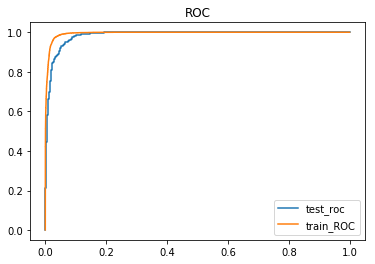

Probability density for train


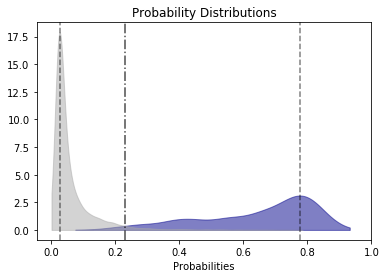

Probability density for test


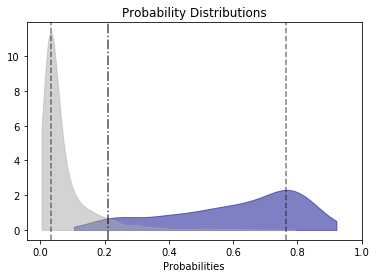


[[2895   44]
 [ 143  364]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2895   44  2939
1           143  364   507
All        3038  408  3446


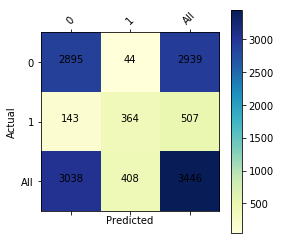

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2939
          1       0.89      0.72      0.80       507

avg / total       0.94      0.95      0.94      3446

ACCURACY 0.9457341845618108
-----------------

AUC_TRAIN =  0.9948387482647005

AUC =  0.9829843054956947


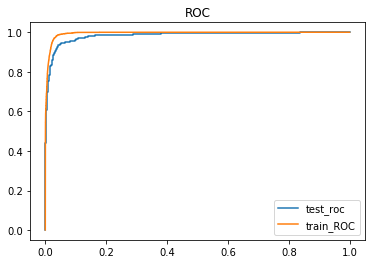

Probability density for train


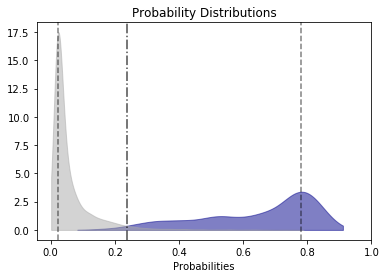

Probability density for test


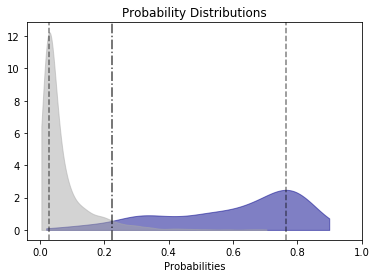


[[2916   22]
 [ 145  362]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2916   22  2938
1           145  362   507
All        3061  384  3445


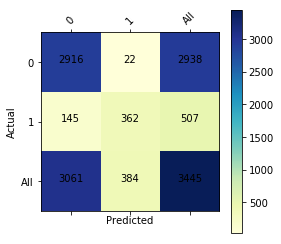

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2938
          1       0.94      0.71      0.81       507

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9515239477503629
-----------------

AUC_TRAIN =  0.9942224314168232

AUC =  0.9866710061097387


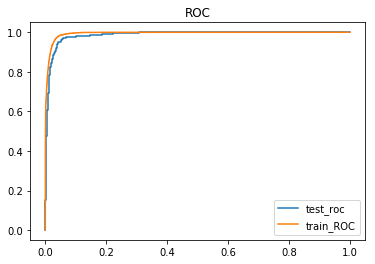

Probability density for train


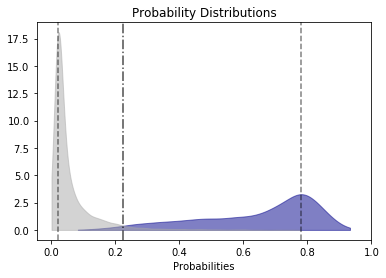

Probability density for test


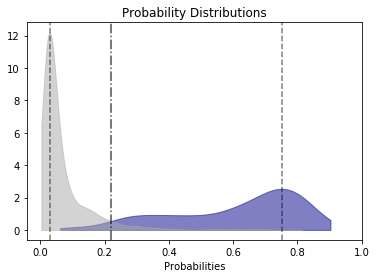


[[2905   34]
 [ 147  359]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2905   34  2939
1           147  359   506
All        3052  393  3445


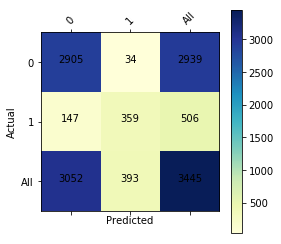

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2939
          1       0.91      0.71      0.80       506

avg / total       0.95      0.95      0.94      3445

ACCURACY 0.9474600870827286
-----------------

AUC_TRAIN =  0.9949300459758827

AUC =  0.9901041959898016


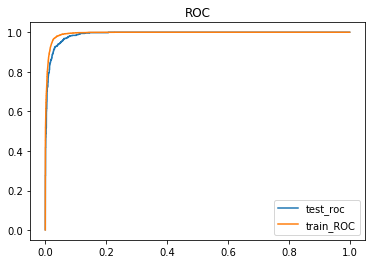

Probability density for train


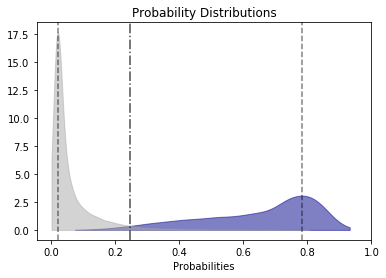

Probability density for test


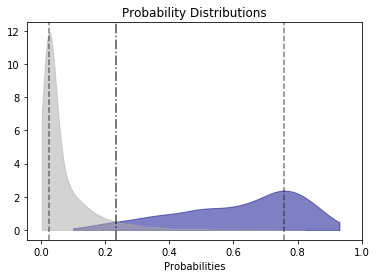


[[2912   25]
 [ 138  370]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2912   25  2937
1           138  370   508
All        3050  395  3445


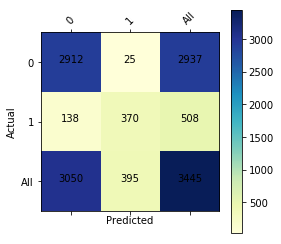

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2937
          1       0.94      0.73      0.82       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9526850507982584
-----------------

AUC_TRAIN =  0.9948513045493603

AUC =  0.988022085850096


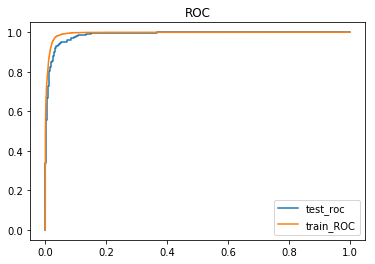

Probability density for train


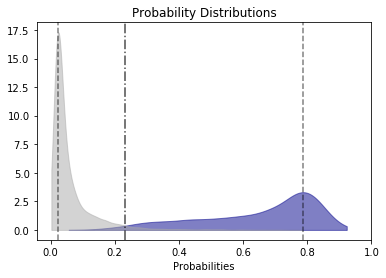

Probability density for test


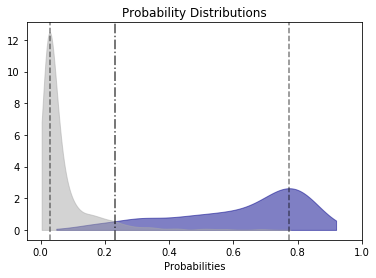


[[2902   35]
 [ 133  375]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2902   35  2937
1           133  375   508
All        3035  410  3445


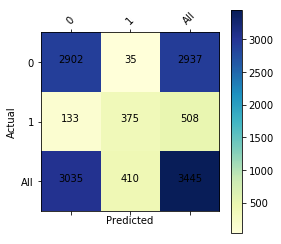

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2937
          1       0.91      0.74      0.82       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9512336719883889
-----------------

AUC_TRAIN =  0.9952337688224931

AUC =  0.9864188643937383


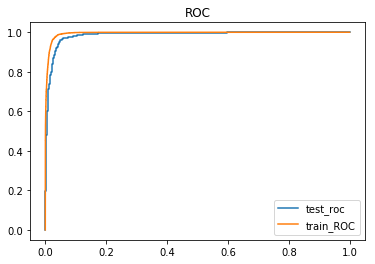

Probability density for train


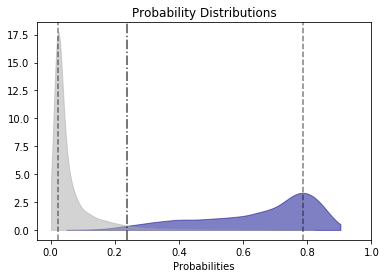

Probability density for test


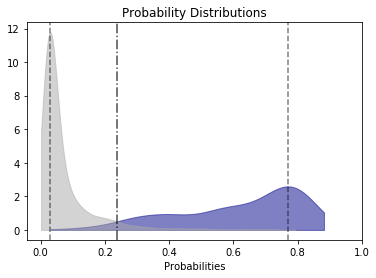


[[2899   38]
 [ 134  374]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2899   38  2937
1           134  374   508
All        3033  412  3445


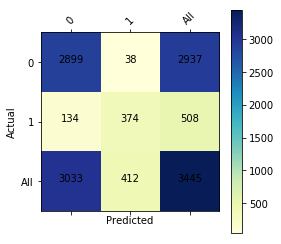

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2937
          1       0.91      0.74      0.81       508

avg / total       0.95      0.95      0.95      3445

ACCURACY 0.9500725689404935
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9950346420376704

AUC =  0.9801030064270375


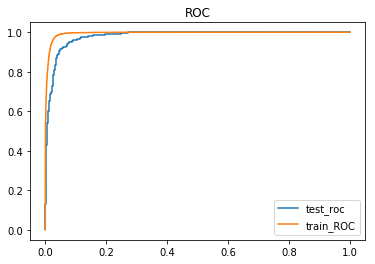

Probability density for train


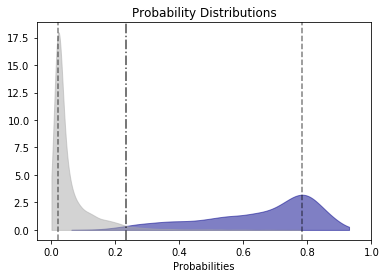

Probability density for test


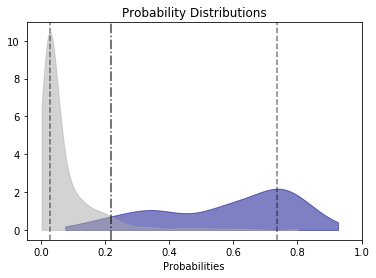


[[1926   31]
 [ 110  231]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1926   31  1957
1           110  231   341
All        2036  262  2298


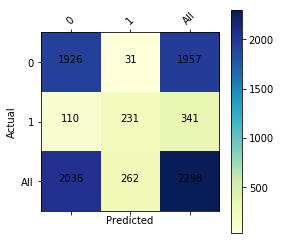

REPORT
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      1957
          1       0.88      0.68      0.77       341

avg / total       0.94      0.94      0.94      2298

ACCURACY 0.9386422976501305
-----------------

AUC_TRAIN =  0.9946355795732849

AUC =  0.9879881935886318


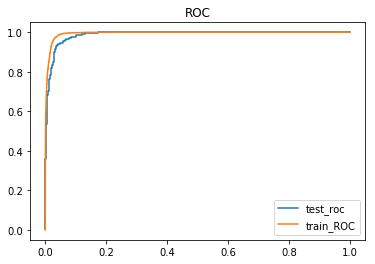

Probability density for train


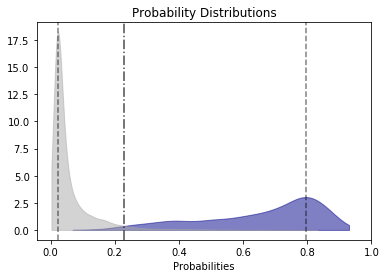

Probability density for test


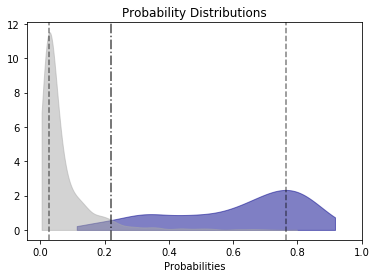


[[1940   22]
 [  97  238]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1940   22  1962
1            97  238   335
All        2037  260  2297


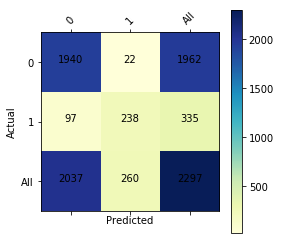

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.71      0.80       335

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9481932956029604
-----------------

AUC_TRAIN =  0.9948831108479925

AUC =  0.9825349724459517


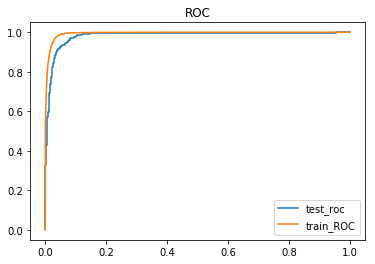

Probability density for train


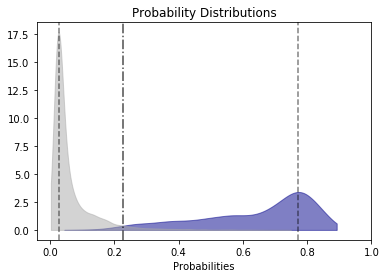

Probability density for test


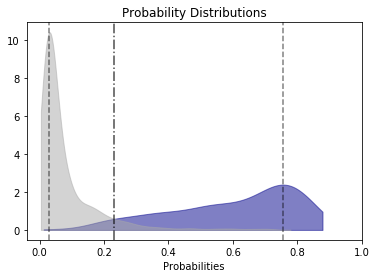


[[1931   29]
 [  95  242]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1931   29  1960
1            95  242   337
All        2026  271  2297


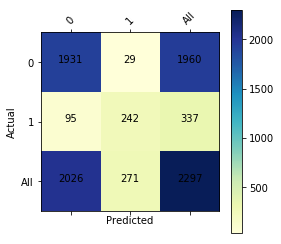

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.89      0.72      0.80       337

avg / total       0.94      0.95      0.94      2297

ACCURACY 0.9460165433173705
-----------------

AUC_TRAIN =  0.9947756149073057

AUC =  0.9890919275722159


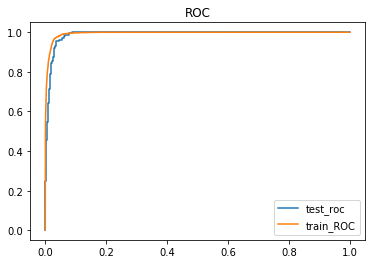

Probability density for train


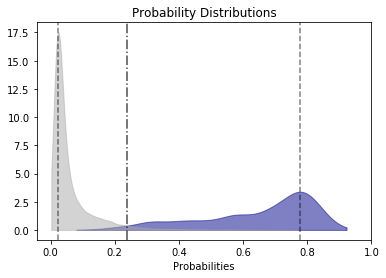

Probability density for test


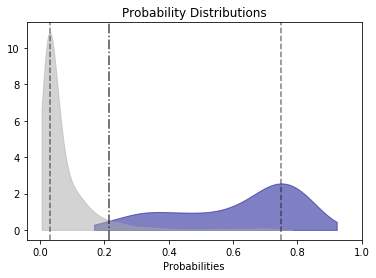


[[1932   28]
 [  95  242]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1932   28  1960
1            95  242   337
All        2027  270  2297


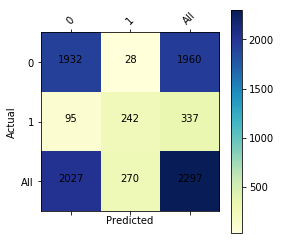

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.90      0.72      0.80       337

avg / total       0.94      0.95      0.94      2297

ACCURACY 0.9464518937744885
-----------------

AUC_TRAIN =  0.9947498132258984

AUC =  0.9850523841222436


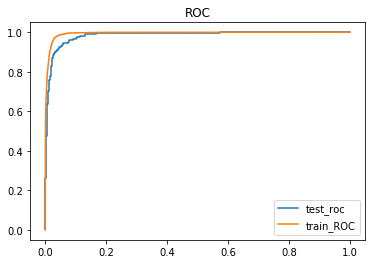

Probability density for train


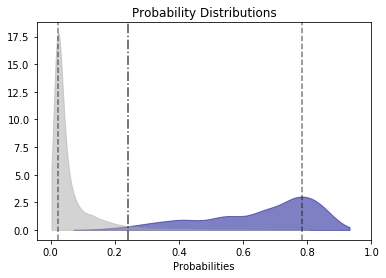

Probability density for test


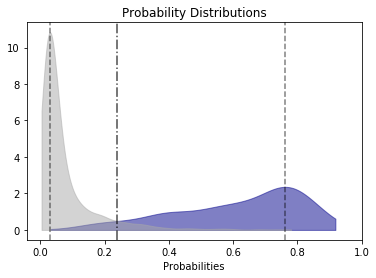


[[1934   22]
 [  95  246]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1934   22  1956
1            95  246   341
All        2029  268  2297


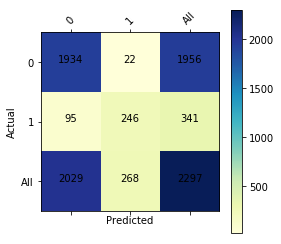

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1956
          1       0.92      0.72      0.81       341

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9490639965171963
-----------------

AUC_TRAIN =  0.9944344286706213

AUC =  0.9912215576061799


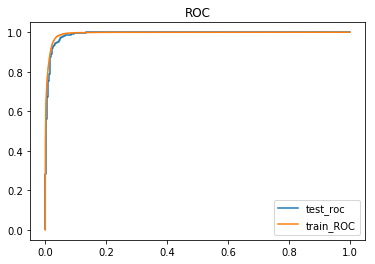

Probability density for train


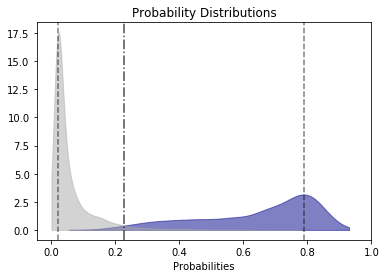

Probability density for test


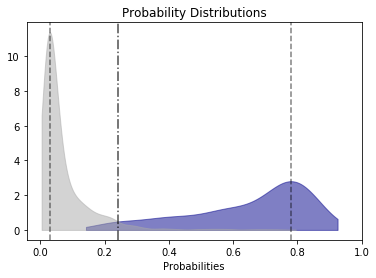


[[1933   24]
 [  73  267]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1933   24  1957
1            73  267   340
All        2006  291  2297


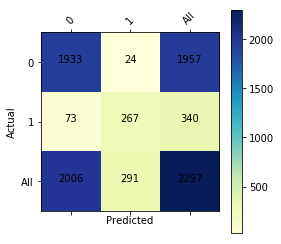

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1957
          1       0.92      0.79      0.85       340

avg / total       0.96      0.96      0.96      2297

ACCURACY 0.957771005659556
-----------------

AUC_TRAIN =  0.9946269021437042

AUC =  0.9846918021821074


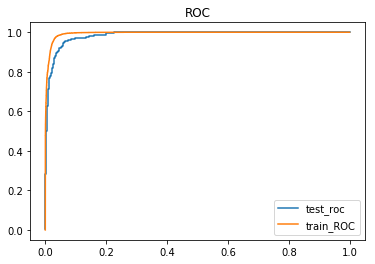

Probability density for train


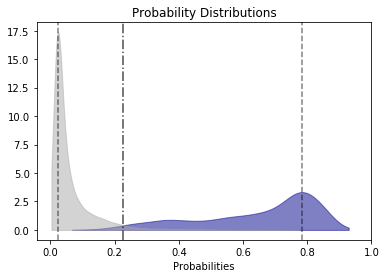

Probability density for test


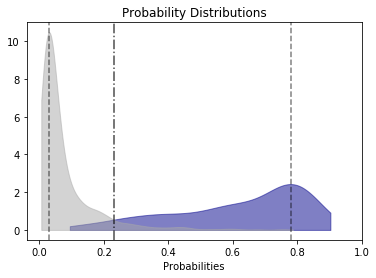


[[1936   22]
 [  92  247]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   22  1958
1            92  247   339
All        2028  269  2297


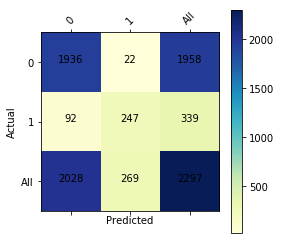

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1958
          1       0.92      0.73      0.81       339

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9503700478885503
-----------------

AUC_TRAIN =  0.9946821436972741

AUC =  0.9858714418722373


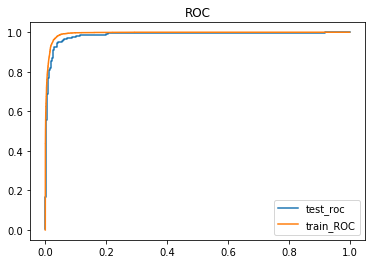

Probability density for train


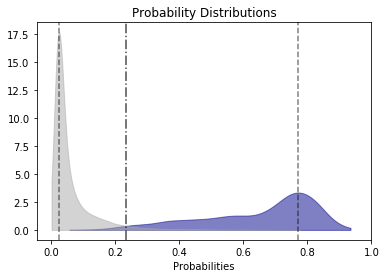

Probability density for test


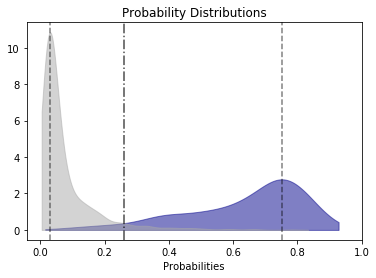


[[1936   22]
 [  75  264]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   22  1958
1            75  264   339
All        2011  286  2297


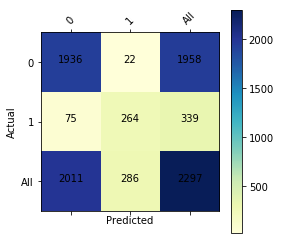

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1958
          1       0.92      0.78      0.84       339

avg / total       0.96      0.96      0.96      2297

ACCURACY 0.957771005659556
-----------------

AUC_TRAIN =  0.9947971625173342

AUC =  0.9871727433947519


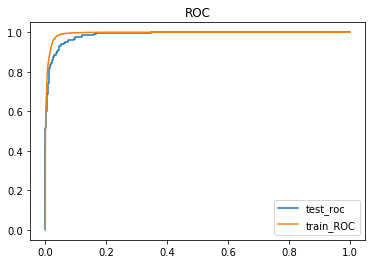

Probability density for train


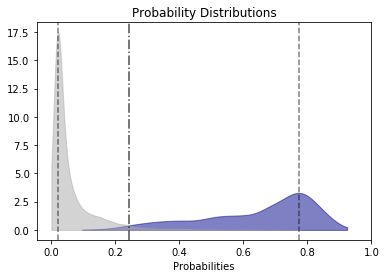

Probability density for test


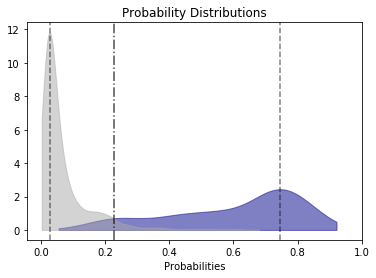


[[1941   16]
 [ 101  239]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   16  1957
1           101  239   340
All        2042  255  2297


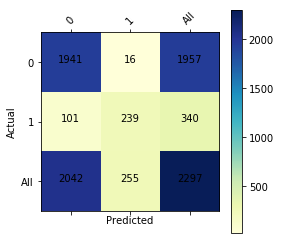

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1957
          1       0.94      0.70      0.80       340

avg / total       0.95      0.95      0.95      2297

ACCURACY 0.9490639965171963
-----------------

AUC_TRAIN =  0.994554198228341

AUC =  0.9907134723367496


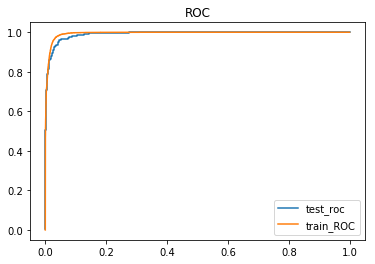

Probability density for train


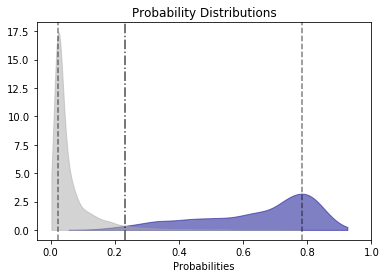

Probability density for test


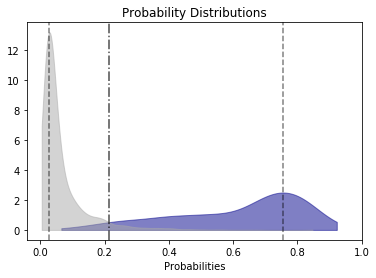


[[1950    9]
 [  95  243]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1950    9  1959
1            95  243   338
All        2045  252  2297


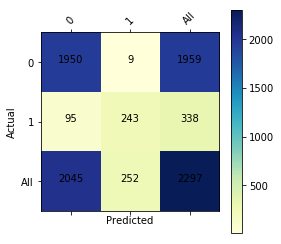

REPORT
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      1959
          1       0.96      0.72      0.82       338

avg / total       0.96      0.95      0.95      2297

ACCURACY 0.9547235524597301
-----------------

AUC_TRAIN =  0.9949907992543756

AUC =  0.9838642281838551


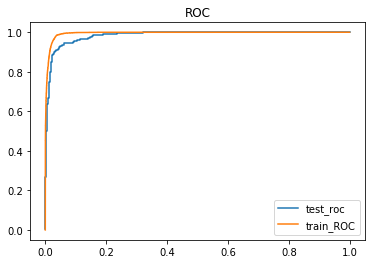

Probability density for train


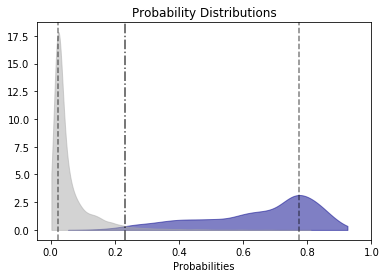

Probability density for test


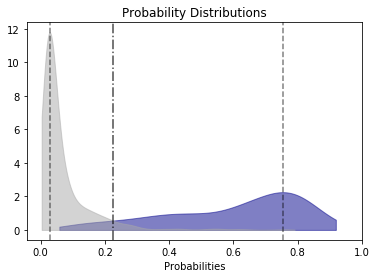


[[1936   24]
 [ 104  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1936   24  1960
1           104  233   337
All        2040  257  2297


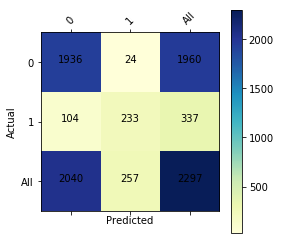

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.91      0.69      0.78       337

avg / total       0.94      0.94      0.94      2297

ACCURACY 0.9442751414888986
-----------------

AUC_TRAIN =  0.9948748135374634

AUC =  0.9851293227132549


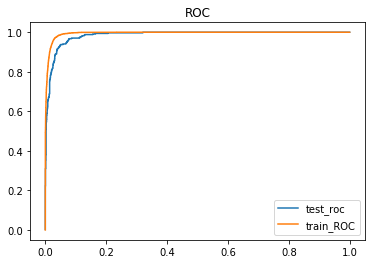

Probability density for train


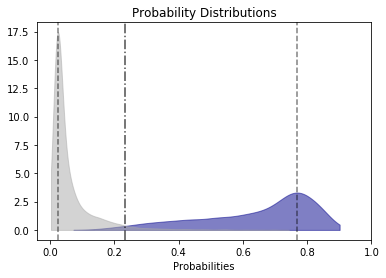

Probability density for test


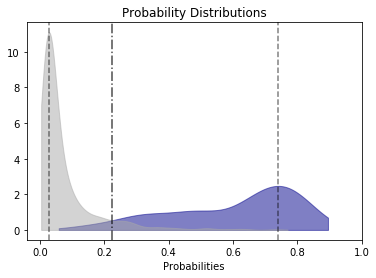


[[1933   26]
 [ 107  231]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1933   26  1959
1           107  231   338
All        2040  257  2297


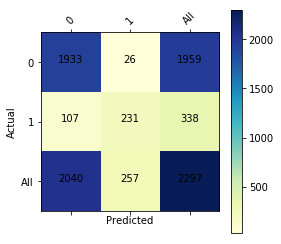

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1959
          1       0.90      0.68      0.78       338

avg / total       0.94      0.94      0.94      2297

ACCURACY 0.9420983892033087
-----------------

AUC_TRAIN =  0.9945890069282444

AUC =  0.9918147971302681


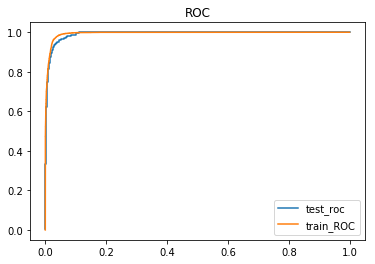

Probability density for train


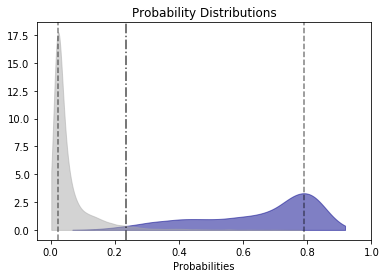

Probability density for test


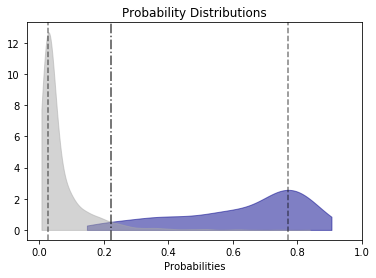


[[1944   14]
 [  87  251]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   14  1958
1            87  251   338
All        2031  265  2296


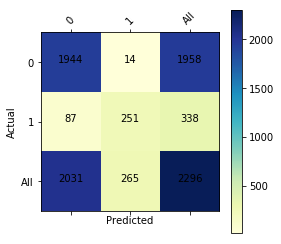

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1958
          1       0.95      0.74      0.83       338

avg / total       0.96      0.96      0.95      2296

ACCURACY 0.9560104529616724
-----------------

AUC_TRAIN =  0.9953187173936965

AUC =  0.9808221887504376


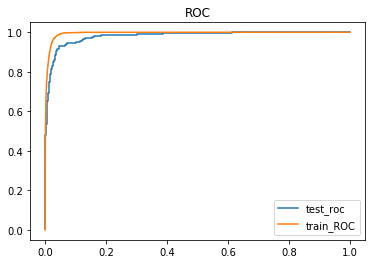

Probability density for train


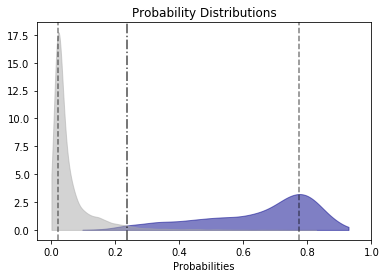

Probability density for test


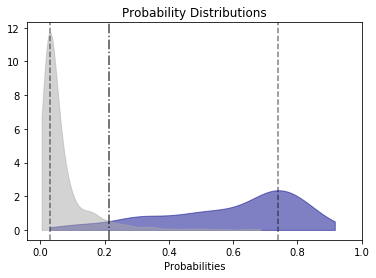


[[1941   21]
 [ 102  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   21  1962
1           102  233   335
All        2043  254  2297


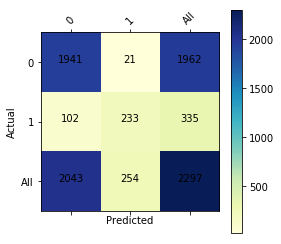

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.70      0.79       335

avg / total       0.95      0.95      0.94      2297

ACCURACY 0.9464518937744885
-----------------

AUC_TRAIN =  0.9947507470374667

AUC =  0.9886525592004363


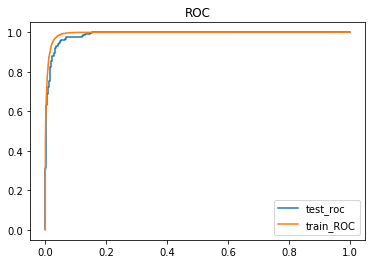

Probability density for train


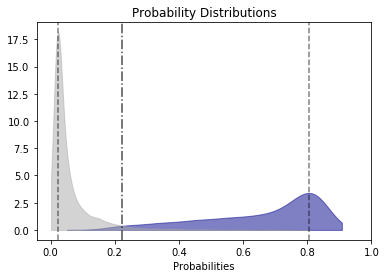

Probability density for test


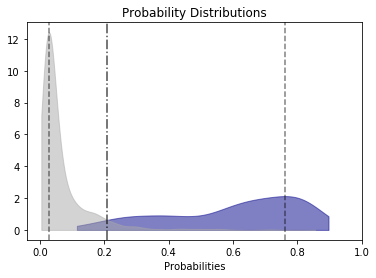


[[1941   17]
 [ 103  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   17  1958
1           103  236   339
All        2044  253  2297


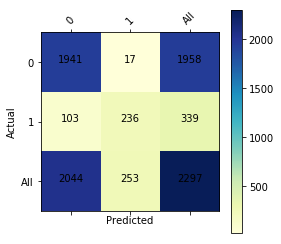

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1958
          1       0.93      0.70      0.80       339

avg / total       0.95      0.95      0.94      2297

ACCURACY 0.9477579451458424
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
